In [1]:
from model import *
from data import *

from importlib import reload  # Python 3.4+ only.
import data
import model as model_functions

reload(data)
reload(model_functions)

Using TensorFlow backend.


<module 'model' from 'D:\\drive\\MyDriveBackup\\9.Semester\\Masterarbeit\\masterarbeit - git\\U-Net\\model.py'>

In [2]:
WIDTH = 256
HEIGHT = 256

combined_folds_dir = "../../Data/Masked Images/k-folds/combined folds"


In [3]:
BATCH_SIZE = 7

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    vertical_flip=True,
                    brightness_range=[0.2,1.8],
                    #validation_split = 0.3,
                    fill_mode="reflect")

def get_generators(train_dir="../../Data/Masked Images/k-folds/combined folds/0/train", val_dir="../../Data/Masked Images/k-folds/combined folds/0/validate"):
    myGene = trainGenerator(BATCH_SIZE
                     ,train_dir
                     ,'image'
                     #,'label'
                     ,'multi-label'
                     ,data_gen_args
                     ,image_color_mode='rgb'
                     ,mask_color_mode='rgb'
                     ,target_size=(WIDTH,HEIGHT)
                     ,save_to_dir = None
                     ,flag_multi_class = True
                     ,num_class = 3
                     ,preprocessing_function=custom_preprocess_input
                       )

    myGeneValidate = trainGenerator(BATCH_SIZE
                     ,val_dir
                     ,'image'
                     #,'label'
                     ,'multi-label'
                     ,data_gen_args
                     ,image_color_mode='rgb'
                     ,mask_color_mode='rgb'
                     ,target_size=(WIDTH,HEIGHT)
                     ,save_to_dir = None
                     ,flag_multi_class = True
                     ,num_class = 3
                     ,preprocessing_function=custom_preprocess_input
                               )
    
    return myGene, myGeneValidate

In [4]:
from keras.applications.densenet import DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(HEIGHT,WIDTH,3))

In [5]:
#TODO: if it doesnt work with these layers, use the layers from "Unet with different decoders - Experiments-Copy1"
#  --> these were already trained successfully before...

#skip_connections:
# conv1/conv (Conv2D)(None, 128, 128, 64)
# pool2_conv (Conv2D)(None, 64, 64, 128)
# pool3_conv (Conv2D)(None, 32, 32, 256)
# pool4_conv (Conv2D)(None, 16, 16, 512)

# for layer in base_model.layers:
#     layer.trainable = False
# easier: base_model.trainable = False

# conv1_output = base_model.get_layer('conv1/conv').output
# conv2_output = base_model.get_layer('pool2_conv').output
# conv3_output = base_model.get_layer('pool3_conv').output
# conv4_output = base_model.get_layer('pool4_conv').output
# base_output = base_model.output


for layer in base_model.layers:
    layer.trainable = False

conv1_output = base_model.get_layer('conv1/conv').output
conv2_output = base_model.get_layer('conv2_block6_concat').output
conv3_output = base_model.get_layer('conv3_block11_concat').output
conv4_output = base_model.get_layer('conv4_block24_concat').output
base_output = base_model.output

In [6]:
def BN_ReLU_Conv(inputs, n_filters, filter_size=3, dropout_p=0.2):
    """
    Apply successivly BatchNormalization, ReLu nonlinearity, Convolution and Dropout (if dropout_p > 0) on the inputs
    """
    
    l = BatchNormalization()(inputs)
    l = ReLU()(l)
    l = Conv2D(n_filters, filter_size, padding="same", kernel_initializer='he_uniform')(l)
    l = Dropout(rate=dropout_p)(l)
    return l

def TransitionUp(skip_connection, block_to_upsample, n_filters_keep):
    """
    Performs upsampling on block_to_upsample by a factor 2 and concatenates it with the skip_connection """

    # Upsample
    l = Concatenate()(block_to_upsample)
    l = Conv2DTranspose(filters=n_filters_keep, kernel_size=3, strides=2, padding='same', kernel_initializer='he_uniform')(l)
    # Concatenate with skip connection
    l = Concatenate()([l, skip_connection])

    return l
    # Note : we also tried Subpixel Deconvolution without seeing any improvements.
    # We can reduce the number of parameters reducing n_filters_keep in the Deconvolution
    
def SoftmaxLayer(inputs, n_classes):
    """
    Performs 1x1 convolution followed by softmax nonlinearity
    The output will have the shape (batch_size  * n_rows * n_cols, n_classes)
    """

    l = Conv2D(n_classes, kernel_size=(1, 1), kernel_initializer='he_uniform', padding='same', activation = softMaxAxis1)(inputs)

    # We perform the softmax nonlinearity in 2 steps :
    #     1. Reshape from (batch_size, n_classes, n_rows, n_cols) to (batch_size  * n_rows * n_cols, n_classes)
    #     2. Apply softmax

#     _, n_rows, n_cols, _ = l.shape
#     size = int(n_rows * n_cols)
#     l = Reshape((size, n_classes))(l)
#     l = Softmax()(l)
    return l


def decoding_path_dense_net(n_pool=4, growth_rate=12, n_layers_per_block=2, dropout_p=0.2):
    # x = Conv2D(1024, (3, 3), padding='same', use_bias=False)(base_output) # to complete dense block...

    x = base_output
    
    skip_connection_list = [conv4_output, conv3_output, conv2_output, conv1_output]
    stack = x
    # We store now the output of the next dense block in a list. We will only upsample these new feature maps
    block_to_upsample = []

    # Dense Block
    for j in range(n_layers_per_block):#[n_pool]):
        l = BN_ReLU_Conv(stack, growth_rate, dropout_p=dropout_p)
        block_to_upsample.append(l)
        stack = Concatenate()([stack, l])
    
    #######################
    #   Upsampling path   #
    #######################

    for i in range(n_pool):
        # Transition Up ( Upsampling + concatenation with the skip connection)
        n_filters_keep = growth_rate * n_layers_per_block#[n_pool + i]
        stack = TransitionUp(skip_connection_list[i], block_to_upsample, n_filters_keep)

        # Dense Block
        block_to_upsample = []
        for j in range(n_layers_per_block):#[n_pool + i + 1]):
            l = BN_ReLU_Conv(stack, growth_rate, dropout_p=dropout_p)
            block_to_upsample.append(l)
            stack = Concatenate()([stack, l])
            
    stack = Conv2DTranspose(filters=n_filters_keep, kernel_size=3, strides=2, padding='same', kernel_initializer='he_uniform')(stack)
    stack = Conv2D(growth_rate, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(stack)

    #####################
    #      Softmax      #
    #####################

    output_layer = SoftmaxLayer(stack, len(COLOR_DICT))
    
    return output_layer
    

In [7]:
import os 
folds_lst = os.listdir(combined_folds_dir)

In [8]:
EPOCHS = 30
STEPS = 44*2
VAL_STEPS = 11*2

#TODO: execute this notebook
histories = {}

for k in folds_lst:
    # checkpoints:
    filepath="../../Models/unet/cross-validation/unet densenet cross validation k = %s.h5" %k 
    filepath_final="../../Models/unet/cross-validation/unet densenent cross validation k = %s train-end.h5" %k 
    model_checkpoint = ModelCheckpoint(filepath, save_weights_only=False, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    
    # generators:
    myGene, myGeneValidate = get_generators(train_dir="%s/%s/train"%(combined_folds_dir, k), val_dir="%s/%s/validate"%(combined_folds_dir, k))
    

    decoder = decoding_path_dense_net(n_pool=4, growth_rate=32, n_layers_per_block=2, dropout_p=0.2)
    model = Model(inputs = base_model.input, outputs = decoder)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes=len(COLOR_DICT))])

    
    print('fold %s of' %k, folds_lst)
    model.fit_generator(myGene
                    , validation_data=myGeneValidate
                    , validation_steps=VAL_STEPS
                    , steps_per_epoch=STEPS
                    , epochs=EPOCHS
                    , callbacks=[model_checkpoint])
    
    histories[k] = model.history.history.copy()
    model.save(filepath_final)

fold 0 of ['0', '1', '2', '3', '4']
Epoch 1/30
Found 7 images belonging to 1 classes.
Found 28 images belonging to 1 classes.
Found 7 images belonging to 1 classes.
Found 28 images belonging to 1 classes.
88/88 [==============================] - 1047s 12s/step - loss: 0.8649 - accuracy: 0.6594 - mean_io_u: 0.3750 - val_loss: 0.9418 - val_accuracy: 0.6589 - val_mean_io_u: 0.3750

Epoch 00001: val_loss improved from inf to 0.94177, saving model to ../../Models/unet/cross-validation/unet densenet cross validation k = 0.h5
Epoch 2/30
88/88 [==============================] - 1036s 12s/step - loss: 0.4186 - accuracy: 0.8519 - mean_io_u: 0.3750 - val_loss: 0.6774 - val_accuracy: 0.7441 - val_mean_io_u: 0.3751

Epoch 00002: val_loss improved from 0.94177 to 0.67742, saving model to ../../Models/unet/cross-validation/unet densenet cross validation k = 0.h5
Epoch 3/30
88/88 [==============================] - 1037s 12s/step - loss: 0.3445 - accuracy: 0.8742 - mean_io_u: 0.3753 - val_loss: 0.7450 

Epoch 2/30
88/88 [==============================] - 1029s 12s/step - loss: 0.4051 - accuracy: 0.8578 - mean_io_u_1: 0.3750 - val_loss: 0.8968 - val_accuracy: 0.5769 - val_mean_io_u_1: 0.3750

Epoch 00002: val_loss improved from 0.93875 to 0.89677, saving model to ../../Models/unet/cross-validation/unet densenet cross validation k = 1.h5
Epoch 3/30
88/88 [==============================] - 1030s 12s/step - loss: 0.3401 - accuracy: 0.8757 - mean_io_u_1: 0.3751 - val_loss: 0.9034 - val_accuracy: 0.5770 - val_mean_io_u_1: 0.3752

Epoch 00003: val_loss did not improve from 0.89677
Epoch 4/30
88/88 [==============================] - 1042s 12s/step - loss: 0.2947 - accuracy: 0.8875 - mean_io_u_1: 0.3752 - val_loss: 0.7884 - val_accuracy: 0.6629 - val_mean_io_u_1: 0.3753

Epoch 00004: val_loss improved from 0.89677 to 0.78838, saving model to ../../Models/unet/cross-validation/unet densenet cross validation k = 1.h5
Epoch 5/30
88/88 [==============================] - 1031s 12s/step - loss: 0.27


Epoch 00002: val_loss improved from 0.91850 to 0.88430, saving model to ../../Models/unet/cross-validation/unet densenet cross validation k = 3.h5
Epoch 3/30
88/88 [==============================] - 1033s 12s/step - loss: 0.3416 - accuracy: 0.8742 - mean_io_u_3: 0.3751 - val_loss: 0.7748 - val_accuracy: 0.7048 - val_mean_io_u_3: 0.3752

Epoch 00003: val_loss improved from 0.88430 to 0.77481, saving model to ../../Models/unet/cross-validation/unet densenet cross validation k = 3.h5
Epoch 4/30
88/88 [==============================] - 1032s 12s/step - loss: 0.3105 - accuracy: 0.8813 - mean_io_u_3: 0.3753 - val_loss: 0.5803 - val_accuracy: 0.7511 - val_mean_io_u_3: 0.3755

Epoch 00004: val_loss improved from 0.77481 to 0.58035, saving model to ../../Models/unet/cross-validation/unet densenet cross validation k = 3.h5
Epoch 5/30
88/88 [==============================] - 1032s 12s/step - loss: 0.2897 - accuracy: 0.8889 - mean_io_u_3: 0.3756 - val_loss: 0.6604 - val_accuracy: 0.7337 - val_mea

88/88 [==============================] - 1034s 12s/step - loss: 0.3366 - accuracy: 0.8742 - mean_io_u_4: 0.3751 - val_loss: 1.1892 - val_accuracy: 0.3967 - val_mean_io_u_4: 0.3752

Epoch 00003: val_loss did not improve from 0.88280
Epoch 4/30
88/88 [==============================] - 1033s 12s/step - loss: 0.2902 - accuracy: 0.8868 - mean_io_u_4: 0.3754 - val_loss: 0.8743 - val_accuracy: 0.5883 - val_mean_io_u_4: 0.3756

Epoch 00004: val_loss improved from 0.88280 to 0.87428, saving model to ../../Models/unet/cross-validation/unet densenet cross validation k = 4.h5
Epoch 5/30
88/88 [==============================] - 1034s 12s/step - loss: 0.2731 - accuracy: 0.8935 - mean_io_u_4: 0.3758 - val_loss: 0.5550 - val_accuracy: 0.7410 - val_mean_io_u_4: 0.3760

Epoch 00005: val_loss improved from 0.87428 to 0.55505, saving model to ../../Models/unet/cross-validation/unet densenet cross validation k = 4.h5
Epoch 6/30
88/88 [==============================] - 1033s 12s/step - loss: 0.2552 - accura

In [9]:
histories

{'0': {'val_loss': [0.9417656660079956,
   0.6774168610572815,
   0.7450197339057922,
   0.5819697976112366,
   0.6174542307853699,
   0.35498562455177307,
   0.4444458782672882,
   0.5937756299972534,
   0.5232897996902466,
   0.47348958253860474,
   0.584719181060791,
   0.5167800188064575,
   0.49121230840682983,
   0.5238643288612366,
   0.6188706159591675,
   0.6576568484306335,
   0.6394567489624023,
   0.48811039328575134,
   0.6283730268478394,
   0.6187908053398132,
   0.6980097889900208,
   0.44923853874206543,
   0.7585490942001343,
   0.5867570638656616,
   0.4619491398334503,
   0.8808053135871887,
   0.7209201455116272,
   0.9282146096229553,
   0.9498792290687561,
   0.8761489987373352],
  'val_accuracy': [0.6589257121086121,
   0.7441247701644897,
   0.7473108768463135,
   0.7710288763046265,
   0.7971245050430298,
   0.8264762759208679,
   0.8320075869560242,
   0.817968487739563,
   0.8359247446060181,
   0.8384231925010681,
   0.8123208284378052,
   0.823982536792755

### fine tune

In [ ]:
#execute in google colab...

In [ ]:
BATCH_SIZE = 7

EPOCHS = 10
STEPS = 44
VAL_STEPS = 11

#TODO: execute this notebook
histories_ft = {}

for k in folds_lst:
    # checkpoints:    
    load_path="../../Models/unet/cross-validation/unet densenent cross validation k = %s train-end.h5" %k 


    filepath="../../Models/unet/cross-validation/unet densenet cross validation k = %s ft.h5" %k 
    filepath_final="../../Models/unet/cross-validation/unet densenet cross validation k = %s ft train-end.h5" %k 
    model_checkpoint = ModelCheckpoint(filepath, save_weights_only=False, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    
    # generators:
    myGene, myGeneValidate = get_generators(train_dir="%s/%s/train"%(combined_folds_dir, k), val_dir="%s/%s/validate"%(combined_folds_dir, k))
    
    decoder = decoding_path_dense_net(n_pool=4, growth_rate=32, n_layers_per_block=2, dropout_p=0.2)
    model = Model(inputs = base_model.input, outputs = decoder)
    model.load_weights(load_path)
    
    for layer in model.layers:
        layer.trainable = True
    model.compile(optimizer = Adam(lr = 1e-5), loss = 'categorical_crossentropy', metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes=len(COLOR_DICT))])
    
    print('fold %s of' %k, folds_lst)
    model.fit_generator(myGene
                    , validation_data=myGeneValidate
                    , validation_steps=VAL_STEPS
                    , steps_per_epoch=STEPS
                    , epochs=EPOCHS
                    , callbacks=[model_checkpoint])
    
    histories_ft[k] = model.history.history.copy()
    model.save(filepath_final)

fold 0 of ['0', '1', '2', '3', '4']


In [ ]:
histories_ft

In [19]:
load_path="../../Models/unet/cross-validation/unet densenet cross validation k = 1 ft.h5" 

decoder = decoding_path_dense_net(n_pool=4, growth_rate=32, n_layers_per_block=2, dropout_p=0.2)
model = Model(inputs = base_model.input, outputs = decoder)
model.load_weights(load_path)

In [22]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

def set_sample_image(file_name, mask_name = None):
    if not mask_name:
        mask_name = file_name
        
    sample_image = image.load_img('../../Data/Masked Images/k-folds/combined folds/1/validate/image/%s'%file_name, target_size=(HEIGHT, WIDTH))
    sample_image = image.img_to_array(sample_image)
#     sample_image /= 255
    #sample_image = np.expand_dims(sample_image, axis=0)

    sample_mask = image.load_img('../../Data/Masked Images/k-folds/combined folds/1/validate/multi-label/%s'%mask_name, target_size=(HEIGHT, WIDTH))
    sample_mask = image.img_to_array(sample_mask)
    sample_mask /= 255
    #sample_mask = np.expand_dims(sample_mask, axis=0)
    
    return sample_image, sample_mask

def create_mask(pred_mask):
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., np.newaxis]
    color_label_matrix = get_color_label_matrix(pred_mask[0])
    return color_label_matrix

def show_predictions():
    plt.figure(figsize=(20,5))
    
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(sample_image/255)
    
    plt.subplot(1, 3, 2)
    plt.title('Ground Truth')
    plt.imshow(sample_mask)
    
    plt.subplot(1, 3, 3)
    plt.title('Predicted')
    pred = model.predict(custom_preprocess_input(sample_image)[np.newaxis, ...])
    plt.imshow(create_mask(pred)[:,:,0])# für matshow: , fignum=False
    
    return pred

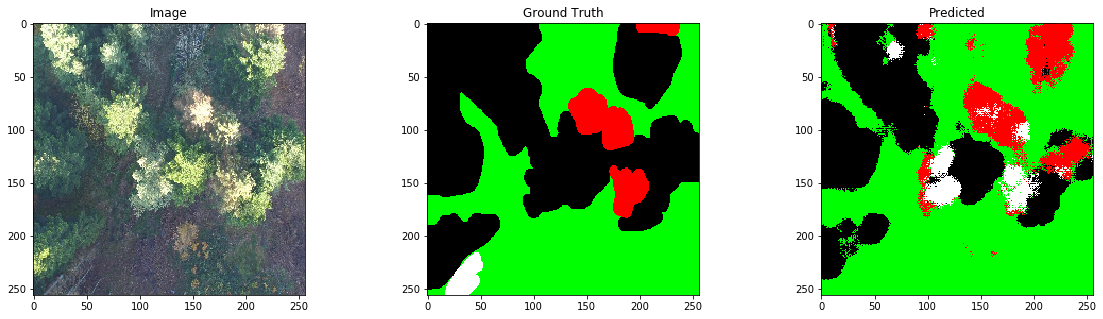

In [23]:
sample_image, sample_mask = set_sample_image('DJI_0219.JPG','DJI_0219.png')
pred = show_predictions()

Text(0.5, 1.0, 'dead')

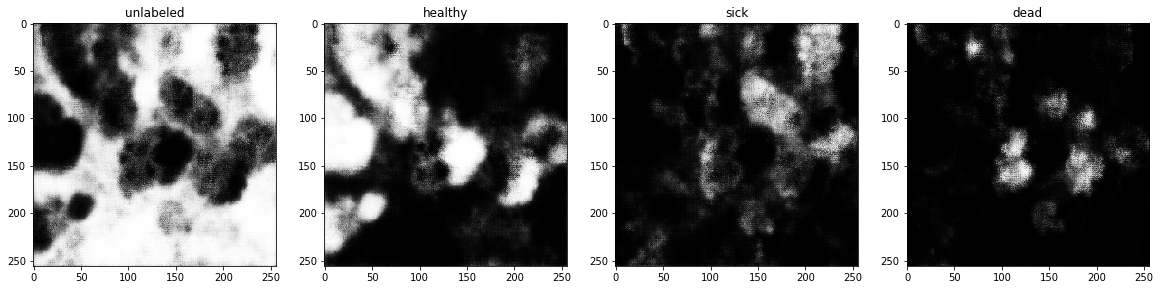

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))

plt.subplot(1, 4, 1)
plt.imshow(pred[0, :,:, 0], vmin=0, vmax=1, cmap='gray')
plt.title('unlabeled')

plt.subplot(1, 4, 2)
plt.imshow(pred[0, :,:, 1], vmin=0, vmax=1, cmap='gray')
plt.title('healthy')

plt.subplot(1, 4, 3)
plt.imshow(pred[0, :,:, 2], vmin=0, vmax=1, cmap='gray')
plt.title('sick')

plt.subplot(1,4,4)
plt.imshow(pred[0, :,:, 3], vmin=0, vmax=1, cmap='gray')
plt.title('dead')

In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

conv3_block5_1_bn (BatchNormali (None, 32, 32, 128)  512         conv3_block5_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block5_1_relu (Activation (None, 32, 32, 128)  0           conv3_block5_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block5_2_conv (Conv2D)    (None, 32, 32, 32)   36864       conv3_block5_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block5_concat (Concatenat (None, 32, 32, 288)  0           conv3_block4_concat[0][0]        
                                                                 conv3_block5_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block6_0_bn (BatchNormali (None, 32, 32, 288)  1152        conv3_block5_concat[0][0]        
__________

conv4_block14_0_bn (BatchNormal (None, 16, 16, 672)  2688        conv4_block13_concat[0][0]       
__________________________________________________________________________________________________
conv4_block14_0_relu (Activatio (None, 16, 16, 672)  0           conv4_block14_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block14_1_conv (Conv2D)   (None, 16, 16, 128)  86016       conv4_block14_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block14_1_bn (BatchNormal (None, 16, 16, 128)  512         conv4_block14_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block14_1_relu (Activatio (None, 16, 16, 128)  0           conv4_block14_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_bloc

In [14]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________